In [1]:
import pandas as pd 
import numpy as np 
import scanpy as sc
import matplotlib.pyplot as plt
import concurrent.futures
import pickle
import warnings
from datetime import date
import hisepy
import os
import shutil
from concurrent.futures import ThreadPoolExecutor, as_completed,ProcessPoolExecutor
from tqdm import tqdm
import anndata
import milopy
import milopy.core as milo
import gc
warnings.filterwarnings("ignore")
sc.settings.n_jobs = 60
print("Current working directory:", os.getcwd())

Current working directory: /home/jupyter/BRI_Figures_Final_V2/Figure2/00_UMAP


# Read MetaData

In [2]:
meta_data=pd.read_csv("/home/jupyter/BRI_Figures_Final_V2//Dataset/scRNA_meta_data-2024-05-09.csv")

# Assemble Year 1 Day 0

In [3]:
meta_data_subset=meta_data[meta_data['sample.visitName'].isin(['Flu Year 1 Day 0','Flu Year 2 Day 0'])]

In [4]:
%%time
file_names= ['/home/jupyter/BRI_Figures/Dataset/scRNA/BRI/h5ad/sample_h5ad/'+x+".h5ad" for x in meta_data_subset['pbmc_sample_id'].tolist()]
adata_list = []
with ThreadPoolExecutor(max_workers=10) as executor:
    future_to_file = {executor.submit(sc.read_h5ad, file_name): file_name for file_name in file_names}
    for future in tqdm(as_completed(future_to_file), total=len(file_names)):
        result = future.result()
        if result is not None:
            adata_list.append(result)

100% 176/176 [06:02<00:00,  2.06s/it]

CPU times: user 22.7 s, sys: 35.3 s, total: 58 s
Wall time: 6min 3s


In [5]:
adata = anndata.concat(adata_list)

In [6]:
%%time
adata.raw=adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

igl_genes = [gene for gene in adata.var_names if gene.startswith("IGL")]
igk_genes = [gene for gene in adata.var_names if gene.startswith("IGK")]
ighc_genes = [gene for gene in adata.var_names if gene.startswith("IGH")]
exl_genes = igl_genes + igk_genes + ighc_genes
mask = ~adata.var_names.isin(exl_genes)
adata = adata[:, mask]
sc.pp.highly_variable_genes(adata)
adata = adata[:, adata.var_names[adata.var['highly_variable']]]

sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=50,use_rep='X_pca', n_pcs=20)
sc.tl.umap(adata,min_dist=0.45,random_state=0)

  0%|          | 0/200 [00:00<?, ?it/s]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
CPU times: user 3h 41min 7s, sys: 2h 41min 15s, total: 6h 22min 22s
Wall time: 1h 22min 28s


IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


In [7]:
adata=adata.raw.to_adata()
adata.write_h5ad('Y1D0_Y2D0_BRI.h5ad')

In [8]:
adata

AnnData object with n_obs × n_vars = 2855403 × 33538
    obs: 'barcodes', 'original_barcodes', 'cell_name', 'batch_id', 'pool_id', 'chip_id', 'well_id', 'n_genes', 'n_reads', 'n_umis', 'total_counts_mito', 'pct_counts_mito', 'doublet_score', 'predicted_AIFI_L1', 'AIFI_L1_score', 'AIFI_L1', 'predicted_AIFI_L2', 'AIFI_L2_score', 'AIFI_L2', 'predicted_AIFI_L3', 'AIFI_L3_score', 'AIFI_L3', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.cmv', 'subject.bmi', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'subject.ageAtFirstDraw', 'sample.visitName', 'sample.drawDate', 'sample.subjectAgeAtDraw', 'specimen.specimenGuid', 'pipeline.fileGuid'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

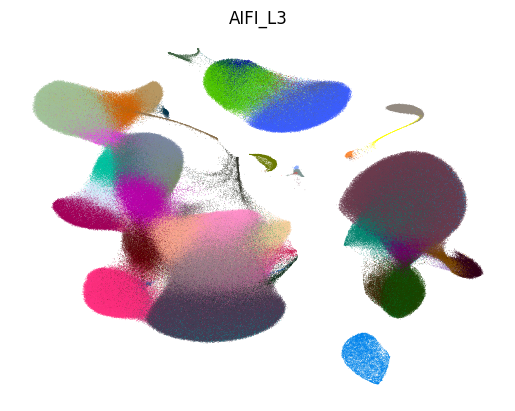

In [10]:
ax=sc.pl.umap(adata, color=['AIFI_L3'], size=0.5,legend_loc=None,ncols=1,frameon=False)
